In [3]:
import pandas as pd
import numpy as np
import os
import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=pd.errors.ParserWarning)

In [4]:
os.listdir("ml_data")

['movies.dat', 'ratings.dat', 'README', 'users.dat']

In [5]:
movies= pd.read_csv("ml_data/movies.dat", encoding="cp1252", delimiter="::", header=None, names=["movie_id", "title", "genres"])
ratings=  pd.read_csv("ml_data/ratings.dat", encoding="cp1252", delimiter="::", header=None, names=["user_id", "movie_id", "rating", "timestamp"])
users=  pd.read_csv("ml_data/users.dat", encoding="cp1252", delimiter="::", header=None, names=["user_id", "gender", "age", "occupation", "zip_code"])

In [6]:
len(movies)

3883

In [7]:
len(ratings)

1000209

In [8]:
len(users)

6040

In [9]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [2]:
!pip3 install sklearn

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates f


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


In [20]:
import torch

# Example 1: Using dim=1 (explicit)
user_emb = torch.randn(4, 8)  # [batch_size, embedding_dim]
movie_emb = torch.randn(4, 8)  # [batch_size, embedding_dim]
x = torch.cat([user_emb, movie_emb], dim=0)

In [21]:
user_emb.shape

torch.Size([4, 8])

In [22]:
movie_emb.shape

torch.Size([4, 8])

In [23]:
x.shape

torch.Size([8, 8])

In [27]:
for i in range(0, len(movie_emb), 2):
    print(i)

0
2


Epoch 1/3, Loss: 43592.132416651584
Epoch 2/3, Loss: 42617.06017038226
Epoch 3/3, Loss: 42458.25688767806
Model saved as neural_linear_bandit_model.pth


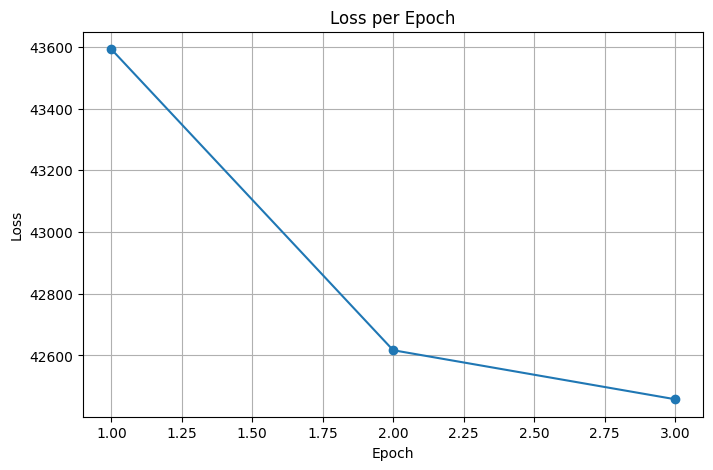

In [61]:
# import necessary packages

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# load dataset

movies= pd.read_csv("ml_data/movies.dat", encoding="cp1252", delimiter="::", header=None, names=["movie_id", "title", "genres"])
ratings=  pd.read_csv("ml_data/ratings.dat", encoding="cp1252", delimiter="::", header=None, names=["user_id", "movie_id", "rating", "timestamp"])
users=  pd.read_csv("ml_data/users.dat", encoding="cp1252", delimiter="::", header=None, names=["user_id", "gender", "age", "occupation", "zip_code"])

# base dataset
base_dt= pd.merge(ratings,movies, on=["movie_id"], how="left")
base_dt= pd.merge(base_dt,users, on=["user_id"], how="left")

# encoding string columns
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

base_dt["userId"] = user_encoder.fit_transform(base_dt["user_id"])
base_dt["movieId"] = movie_encoder.fit_transform(base_dt["movie_id"])

num_users = base_dt["userId"].nunique()
num_movies = base_dt["movieId"].nunique()

# prepare for train dataset
base_dt['target']=0
base_dt.loc[base_dt['rating']>=4,'target']=1
used_features= ['userId','movieId','target']

# setting modeling part
class nn_linear_bandit_model(nn.Module):

    def __init__(self, num_users, num_movies, embedding_dim=8):
        super(nn_linear_bandit_model, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)

        self.mlp = nn.Sequential(

            nn.Linear(embedding_dim * 2, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, 1),
            nn.Sigmoid()

        )

    def forward(self, user_ids, movie_ids):
        user_emb= self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(movie_ids)
        x= torch.cat([user_emb, movie_emb], dim=-1)
        return self.mlp(x)


# setting train model
def train_neural_linear_bandit_model(model, samples, epochs=3, batch_size=32):
    optimizer= optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    model.train()

    loss_history = []  # save loss records

    for epoch in range(epochs):

        total_loss=0

        for i in range(0, len(samples), batch_size):
            batch= samples[i:i+batch_size]

            user_ids, movie_ids, labels = zip(*batch)

            user_ids= torch.tensor(user_ids, dtype=torch.long)
            movie_ids= torch.tensor(movie_ids, dtype=torch.long)
            labels= torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

            optimizer.zero_grad()
            predictions= model(user_ids, movie_ids)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            total_loss+=loss.item()

        loss_history.append(total_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

    # Save the model
    torch.save(model.state_dict(), "neural_linear_bandit_model.pth")
    print("Model saved as neural_linear_bandit_model.pth")

    # Plot the loss history
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), loss_history, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.grid()
    plt.show()

# debug
# print(base_dt.head())
# print(base_dt.info())
# print(len(base_dt))

# print(train_dt.head())
# print(train_dt.info())
# print(len(train_dt))

def generate_negative_samples(data, num_negative=4):
    """Generate negative samples for the training dataset."""
    samples = []
    all_movies = set(data["movieId"].unique())

    for _, row in data.iterrows():
        user_id = row["userId"]
        positive_movie = row["movieId"]
        label = row["target"]

        # Add positive sample
        samples.append((user_id, positive_movie, label))

        # Add negative samples
        negative_movies = np.random.choice(list(all_movies - {positive_movie}), num_negative, replace=False)

        for neg_movie in negative_movies:
            samples.append((user_id, neg_movie, 0))  # Negative samples have label 0

    return samples

train_samples = generate_negative_samples(base_dt[used_features])

# param
embedding_dim= 4

# train model
model = nn_linear_bandit_model(num_users, num_movies, embedding_dim)
train_neural_linear_bandit_model(model, train_samples)